In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIPS
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', context='talk')
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

names = ['001','002','003','004','005','007','010','011','012',
         '013','015','016','017','018','019','020','021','022',
        '024','026','029','032','033','038','039','040','041','045','047']

types = ['Cepheid','RRab','RRc','RRc','RRc','RRc','RRc','RRc',
        'RRab','RRab','RRab','RRc','RRd','RRc','RRab','RRab',
        'RRab','RRab','RRc','RRc','RRab','RRab','RRab','RRc',
        'RRd','RRc','RRc','RRab','RRab']

periods = [1.439196986,0.683963897,0.388829892,0.313798307,0.384857593,
           0.36799942,0.387064059,0.343230346,0.592372007,0.574718918,
           0.584949025,0.396811743,0.428460262,0.367770602,
            0.572770103,0.697068653,0.648254847,0.720185674,
            0.36990130,0.404819381,0.574868832,0.603046912,
            0.586230576,0.375549084,0.388420314,0.377039219,0.392387222,
            0.677425869,0.688737938]

P_errors = [0.000000555,0.000000284,0.000000099,0.000000053,0.000000339,
            0.000000767,0.000000304,0.000000090,0.000000089,0.00003310,
            0.000000150,0.000000167,0.000000521,0.000000165,0.000000692,
            0.000000115,0.000000327,0.000000243,0.000001634,
            0.000000068,0.000000662,0.000000252,0.000000210,
            0.000003812,0.000000102,0.000000093,0.000000071,
            0.000000158,0.000000705]

index = []
for i in names:
    index.append('V' + i)

summary = pd.DataFrame({'ID': index, 'Type': types, 'period':periods, 'P Error':P_errors}).set_index('ID').sort_values(by='ID')

summary

objects = []

In [52]:

for i in range(len(names)):
    data_Vi = PIPS.data_readin_LPP('Data/' + names[i] + '.dat',filter='V')
    phot_obj = PIPS.photdata(data_Vi)
    filtered_data = phot_obj.phot_err_cut()
    filtered_data.type = types[i]
    filtered_data.period = periods[i]
    filtered_data.period_err = P_errors[i]
    filtered_data.epoch = filtered_data.get_epoch()
    objects.append(filtered_data)

In [53]:
#objects[0].epoch[0]

objects[1].period_err

2.84e-07

In [54]:
def fit_cphi(x,y,period,K):
    def f(x_folded,A0,*cp_list):
        c_list = cp_list[0:K]
        p_list = cp_list[K:]
        y = A0
        for i in range(len(c_list)):
            y += c_list[i]*np.cos((i+1)*2*np.pi*x_folded/period + p_list[i])
        return y
    
    p0 = [1,*np.zeros(K*2)]
    popt,pcov = curve_fit(f,x%period,y,p0=p0)
    return popt,pcov

"""RRab Type Star Functions for Stellar Properties"""

def Fe_H_ab(period, phi):
    phi_s = phi + np.pi + 0.151
    return -5.241 - 5.394*period + 1.345*phi_s

def BV_0(period, C_1, C_3):
    return 0.189*np.log10(period) -0.313*C_1 + 0.293*C_3 + 0.460

def log_T_eff_type_ab(BV, metallicity):
    return 3.930 - 0.322*BV + 0.007*metallicity

def M_v_ab(period, C_1, C_3):
    return -1.876*np.log10(period) - 1.158*C_1 + 0.821*C_3 + 0.43

def log_L_ab(period,C_1, C_3):
    M_v = -1.876*np.log10(period) - 1.158*C_1 + 0.821*C_3 + 0.43
    return (M_v - 4.83)/(-2.5)

def log_mass_ab(period, log_L, log_T_eff, metal):
    return 20.844 - 1.754*np.log10(period) + 1.477*(log_L) - 6.272*log_T_eff + 0.0367*metal


def error_Fe_H_ab(p_err, phi_err):
    return np.sqrt((-5.394*p_err)**2 + (1.345*phi_err)**2)

def error_BV_0(period,p_err, C_1_err, C_3_err):
    return np.sqrt(((0.189/np.log(10))*(p_err/period))**2 + (-0.313*C_1_err)**2 + (0.293*C_3_err)**2)

def error_log_T_eff_type_ab(BV_err, metallicity_err):
    return np.sqrt((0.322*BV_err)**2 + (0.007*metallicity_err)**2)

def error_M_v_ab(period, p_err, C_1_err, C_3_err):
    return np.sqrt(((-1.876/np.log(10))*(p_err/period))**2 + (-1.158*C_1_err)**2 + (0.821*C_3_err)**2)

def error_log_L_ab(period,p_err,C_1_err, C_3_err):
    L_err = np.sqrt((((1.876/2.5)/np.log(10))*(p_err/period))**2 + (1.158*C_1_err/2.5)**2 + (0.821*C_3_err/2.5)**2)
    return L_err 

def error_log_mass_ab(period,p_err, log_L_err, log_T_eff_err, metal_err):
    return np.sqrt(((-1.754/np.log(10))*(p_err/period))**2 + (1.477*(log_L_err))**2 + (-6.272*log_T_eff_err)**2 + (0.0367*metal_err)**2)
    

"""RRc Type Star Functions for Stellar Properties"""

def Fe_H_c(period, phi):
    #phi is phi_31
    phi_s = phi + np.pi
    return 0.0348*phi_s**2 + 0.196*phi - 8.507*period + 0.367

def log_T_eff_type_c(period, phi):
    phi_s = phi + np.pi #not sure if I should have the kepler version here
    return 3.7746 - 0.1452*np.log10(period) + 0.0056*phi_s

def M_v_c(period, phi, C4):
    #phi is phi_21 in cosine basis
    phi_s = phi - np.pi/2
    return 1.061 - 0.961*np.log10(period) - 0.044*phi_s - 4.447*C4

def log_L_c(period,phi, C4):
    phi_s = phi - np.pi/2
    M_v = 1.061 - 0.961*np.log10(period) - 0.044*phi_s - 4.447*C4
    return (M_v - 4.83)/(-2.5)

def log_mass_c(period, phi):
    phi_s = phi + np.pi
    return 0.52 * np.log10(period) - 0.11*phi_s + 0.39


def error_Fe_H_c(p_err, phi_err, phi):
    #phi is phi_31
    phi_s = phi + np.pi
    return (2*0.0348*phi_s * phi_err)**2 + (0.196*phi_err)**2 + (-8.507*p_err)**2

def error_log_T_eff_type_c(period,p_err, phi_err):
    #phi_s = phi + np.pi 
    return np.sqrt(((- 0.1452/np.log(10))*(p_err/period))**2 + (0.0056*phi_err)**2)

def error_M_v_c(period,p_err, phi_err, C4_err):
    return np.sqrt(((- 0.961/np.log(10))*(p_err/period))**2 + (-0.044*phi_err)**2 +  (-4.447*C4_err)**2)

def error_log_L_c(period,p_err, phi_err, C4_err):
    L_err = (((0.961/2.5)/np.log(10))*(p_err/period))**2 + (- 0.044*phi_err/2.5)**2 + (-4.447*C4_err/2.5)**2
    return L_err

def error_log_mass_c(period,p_err, phi_err):
    return np.sqrt(((0.52/np.log(10))*(p_err/period))**2 + (-0.11*phi_err)**2)

"""Functions for all stars"""

def log_surface_gravity(log_mass, log_L, log_T_eff):
    return -10.607 + log_mass - log_L + 4*log_T_eff

def error_log_surface_gravity(log_mass_err, log_L_err, log_T_eff_err):
    return np.sqrt(log_mass_err**2  + log_L_err**2 + (4*log_T_eff_err)**2)
    

In [76]:
print(objects[0].type)

K=4

# initialize new columns
for col in ['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']:
    summary[col] = np.nan

for col in ['[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']:
    summary[col] = np.nan
    
for col in ['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']:
    summary[col] = np.nan

for col in ['err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']:
    summary[col] = np.nan

# get values
for i in range(len(objects)):
    if objects[i].type == 'RRab':
        star = objects[i]
        name = index[i]
        popt,pcov = fit_cphi(star.x-star.epoch[0]%star.period,star.y,star.period,K=4)
        
        errors = []
        for j in range(len(popt)):
            err = np.sqrt(pcov[j,j])
            errors.append(err)

        err_c_1, err_c_2, err_c_3, err_c_4 = errors[1], errors[2], errors[3], errors[4]
        err_phi21 = np.sqrt( (errors[6])**2 + (-2 * errors[5])**2 )
        err_phi31 = np.sqrt( (errors[7])**2 + (-3 * errors[5])**2 )
        err_phi41 = np.sqrt( (errors[8])**2 + (-4 * errors[5])**2 )
        
        for i in range(K):
            if popt[i+1]<0:
                popt[i+K+1] += np.pi
                popt[i+1] *= -1
            popt[i+5] = popt[i+5]%(2*np.pi)

        c_1, c_2, c_3, c_4 = popt[1], popt[2], popt[3], popt[4]
        phi21 = (popt[6] - 2*popt[5])%(2*np.pi)
        phi31 = (popt[7] - 3*popt[5])%(2*np.pi)
        phi41 = (popt[8] - 4*popt[5])%(2*np.pi)
        ['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']

        Fe_H_value = Fe_H_ab(star.period, phi31)
        BV_0_value = BV_0(star.period,c_1, c_3)
        log_T_eff_value = log_T_eff_type_ab(BV_0_value, Fe_H_value)
        M_v_value = M_v_ab(star.period, c_1, c_3)
        log_L_value = log_L_ab(star.period, c_1, c_3)
        log_mass_value = log_mass_ab(star.period, log_L_value, log_T_eff_value, Fe_H_value)
        log_g_value = log_surface_gravity(log_mass_value, log_L_value, log_T_eff_value)
        
        error_Fe_H_value = error_Fe_H_ab(star.period_err, err_phi31)
        error_BV_0_value = error_BV_0(star.period,star.period_err,err_c_1, err_c_3)
        error_log_T_eff_value = error_log_T_eff_type_ab(error_BV_0_value, error_Fe_H_value)
        error_M_v_value = error_M_v_ab(star.period,star.period_err, err_c_1, err_c_3)
        error_log_L_value = error_log_L_ab(star.period,star.period_err, err_c_1, err_c_3)
        error_log_mass_value = error_log_mass_ab(star.period,star.period_err, error_log_L_value, error_log_T_eff_value, error_Fe_H_value)
        error_log_g_value = error_log_surface_gravity(error_log_mass_value, error_log_L_value, error_log_T_eff_value)


        summary.loc[name,['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']] = [c_1,c_2,c_3,c_4,phi21,phi31,phi41]
        summary.loc[name,['[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']] = [Fe_H_value, BV_0_value,log_T_eff_value, M_v_value,
                                                                                         log_L_value, 10**log_mass_value, log_g_value]
    
        summary.loc[name,['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']] = [err_c_1,err_c_2,err_c_3,err_c_4,
                                                                                                                err_phi21,err_phi31,err_phi41]
        summary.loc[name,['err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']] = [error_Fe_H_value,error_BV_0_value, error_log_T_eff_value,
                                                                                                                       error_M_v_value, error_log_L_value,
                                                                                                                       error_log_mass_value, error_log_g_value]
    elif objects[i].type == 'RRc':
        # get values
        star = objects[i]
        name = index[i]
        popt,pcov = fit_cphi(star.x-star.epoch[0]%star.period,star.y,star.period,K=4)
        
        errors = []
        for j in range(len(popt)):
            err = np.sqrt(pcov[j,j])
            errors.append(err)

        err_c_1, err_c_2, err_c_3, err_c_4 = errors[1], errors[2], errors[3], errors[4]
        err_phi21 = np.sqrt( (errors[6])**2 + (-2 * errors[5])**2 )
        err_phi31 = np.sqrt( (errors[7])**2 + (-3 * errors[5])**2 )
        err_phi41 = np.sqrt( (errors[8])**2 + (-4 * errors[5])**2 )
    
        for i in range(K):
            if popt[i+1]<0:
                popt[i+K+1] += np.pi
                popt[i+1] *= -1
            popt[i+5] = popt[i+5]%(2*np.pi)

        c_1, c_2, c_3, c_4 = popt[1], popt[2], popt[3], popt[4]
        phi21 = (popt[6] - 2*popt[5])%(2*np.pi)
        phi31 = (popt[7] - 3*popt[5])%(2*np.pi)
        phi41 = (popt[8] - 4*popt[5])%(2*np.pi)

        Fe_H_value = Fe_H_c(star.period, phi31)
        log_T_eff_value = log_T_eff_type_c(star.period, phi31)
        M_v_value = M_v_c(star.period, phi21, c_4)
        log_L_value = log_L_c(star.period, phi21, c_4)
        log_mass_value = log_mass_c(star.period, phi31)
        log_g_value = log_surface_gravity(log_mass_value, log_L_value, log_T_eff_value)
        
        error_Fe_H_value = error_Fe_H_c(star.period_err, err_phi31, phi31)
        error_log_T_eff_value = error_log_T_eff_type_c(star.period,star.period_err, err_phi31)
        error_M_v_value = error_M_v_c(star.period,star.period_err, err_phi21, err_c_4)
        error_log_L_value = error_log_L_c(star.period,star.period_err, err_phi21, err_c_4)
        error_log_mass_value = error_log_mass_c(star.period,star.period_err, err_phi31)
        error_log_g_value = error_log_surface_gravity(error_log_mass_value, error_log_L_value, error_log_T_eff_value)


        summary.loc[name,['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']] = [c_1,c_2,c_3,c_4,phi21,phi31,phi41]
        summary.loc[name,['[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']] = [Fe_H_value, log_T_eff_value, M_v_value,
                                                                                 log_L_value, 10**log_mass_value, log_g_value]
        
        summary.loc[name,['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']] = [err_c_1,err_c_2,err_c_3,err_c_4,
                                                                                                            err_phi21,err_phi31,err_phi41]
        summary.loc[name,['err_[Fe/H]','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']] = [error_Fe_H_value, error_log_T_eff_value,
                                                                                                           error_M_v_value, error_log_L_value,
                                                                                                           error_log_mass_value, error_log_g_value]

Cepheid


In [77]:
RRab = summary['Type']=='RRab'
RRc = summary['Type']=='RRc'

summary

,Type,period,P Error,C_1,C_2,C_3,C_4,phi_21,phi_31,phi_41,...,err_phi_21,err_phi_31,err_phi_41,err_[Fe/H],err_BV_0,err_log T_eff,err_M_v,err_log L,err_mass,err_log g
ID,,,,,,,,,,,,,,,,,,,,,
V001,Cepheid,1.439197,5.550000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V002,RRab,0.683964,2.840000e-07,0.146148,0.087709,0.038406,0.014994,3.881000,2.127875,0.010066,...,0.143461,0.234923,0.456455,0.315971,0.002008,0.002304,0.006750,0.002700,0.018954,0.021249
V003,RRc,0.388830,9.900000e-08,0.242539,0.042168,0.032939,0.011787,4.824066,2.668214,5.900371,...,0.171437,0.214683,0.589209,0.009306,NaN,0.001202,0.030386,0.000148,0.023615,0.024100
V004,RRc,0.313798,5.300000e-08,0.297858,0.089907,0.022537,0.018073,4.451751,2.508036,0.981646,...,0.053298,0.197005,0.221774,0.007492,NaN,0.001103,0.018534,0.000055,0.021671,0.022115
V005,RRc,0.384858,3.390000e-07,0.250111,0.039186,0.013587,0.020346,4.274497,2.869771,2.953707,...,0.174043,0.486782,0.338953,0.050583,NaN,0.002726,0.028305,0.000128,0.053546,0.054645
V007,RRc,0.367999,7.670000e-07,0.255065,0.090168,0.040487,0.025397,5.363553,3.460961,5.458803,...,0.194605,0.387231,0.607037,0.037426,NaN,0.002168,0.060259,0.000581,0.042595,0.043474
V010,RRc,0.387064,3.040000e-07,0.262302,0.046541,0.020469,0.026292,4.631480,3.644887,2.275195,...,0.154080,0.327399,0.249305,0.028032,NaN,0.001833,0.031092,0.000155,0.036014,0.036753
V011,RRc,0.343230,9.000000e-08,0.276361,0.076020,0.028764,0.018704,4.441709,2.513607,1.803956,...,0.075403,0.170598,0.251379,0.005627,NaN,0.000955,0.019966,0.000064,0.018766,0.019151
V012,RRab,0.592372,8.900000e-08,0.270432,0.113747,0.088422,0.058963,3.760289,1.211625,5.470335,...,0.114048,0.162457,0.221434,0.218504,0.004672,0.002145,0.015863,0.006345,0.018254,0.021145


-1.879209336776744
-1.0625946726418813


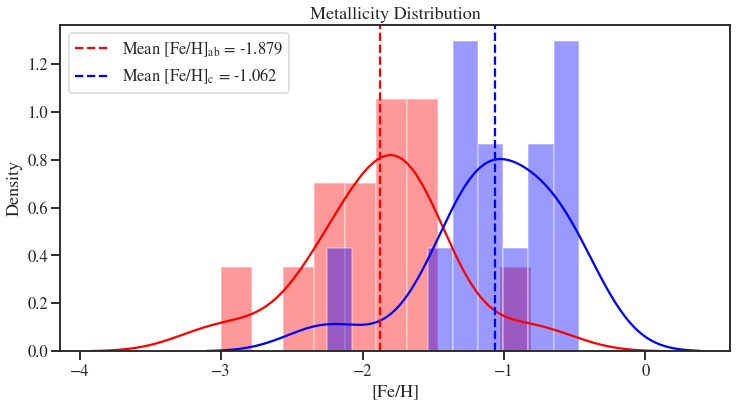

In [57]:
metallicity_ab = summary[RRab]['[Fe/H]']
metallicity_c = summary[RRc]['[Fe/H]']
mean_ab = np.mean(metallicity_ab[metallicity_ab<0])
print(mean_ab)

mean_c = np.mean(metallicity_c[metallicity_c<0])
print(mean_c)
plt.figure(figsize=(12,6))
plt.title("Metallicity Distribution")
sns.distplot(metallicity_ab[metallicity_ab<0],bins=10, color='red')
sns.distplot(metallicity_c[metallicity_c<0],bins=10,color='blue')
plt.axvline(mean_ab,label="Mean $[\mathrm{Fe/H}]_{\mathrm{ab}}$ = -1.879", c='red', linestyle='--')
plt.axvline(mean_c,label="Mean $[\mathrm{Fe/H}]_{\mathrm{c}}$ = -1.062",c='blue', linestyle='--')
plt.legend()
plt.savefig('metallicity_160.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

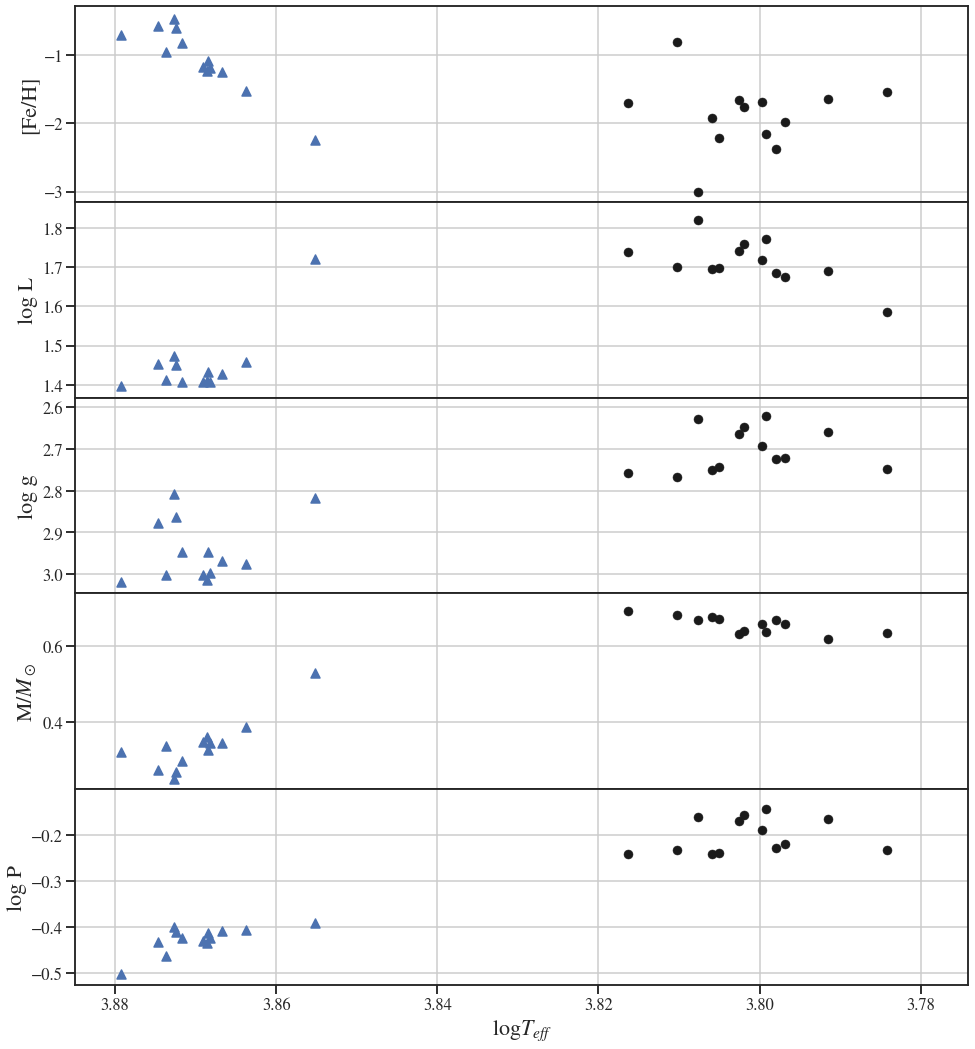

In [58]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)


ax1.set_ylabel("[Fe/H]",fontsize=22)
ax1.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab, color='k', linewidth='0.5')
ax1.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c, color='b', marker='^')
#ax1.scatter(empirical_temp, metallicity, color='r')
ax1.grid()

ax2.set_ylabel("log L",fontsize=22)
ax2.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax2.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
ax2.grid()

ax3.set_ylabel("log g",fontsize=22)
ax3.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax3.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
ax3.invert_yaxis()
ax3.grid()

ax4.set_ylabel("M/$M_\odot$",fontsize=22)
ax4.set_xlabel("$\\log T_{eff}$",fontsize=22)
ax4.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax4.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax4.grid()

ax5.set_ylabel("log P",fontsize=22)
ax5.set_xlabel("$\\log T_{eff}$",fontsize=22)
ax5.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), color='k', linewidth='0.5')
ax5.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]), color='b', marker='^',label='Theoretical')
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax5.grid()

#ax4.set_ylim(.4,1)
#plt.xlim(3.74, 3.86)
#plt.legend()
ax5.invert_xaxis()
plt.savefig('prop_vs_Teff_KAIT.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

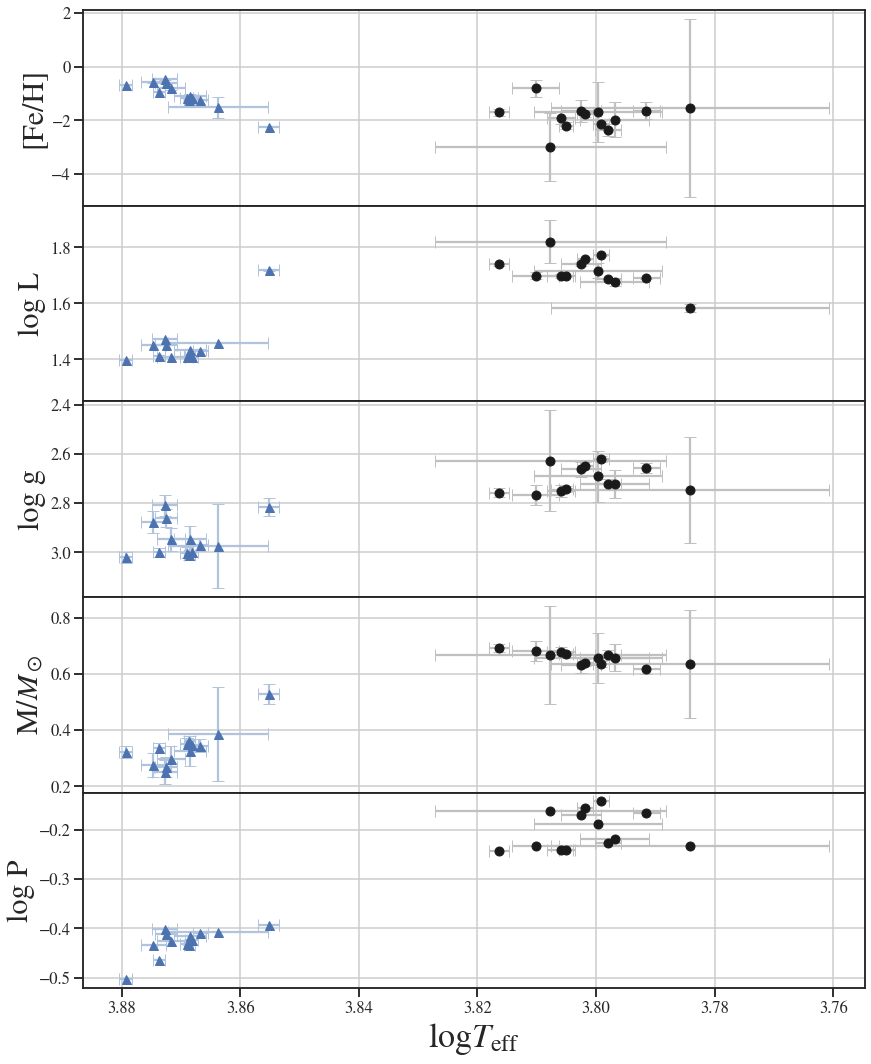

In [83]:
#create a figure with 2 graphs oriented one way
#create a figure with 2 graphs oriented one way
metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
metallicity_c = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 
#empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(14,18),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)


ax1.set_ylabel("[Fe/H]",fontsize=30)
ax1.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab,
             summary[RRab]['err_[Fe/H]'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)

ax1.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c,
            summary[RRc]['err_[Fe/H]'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax1.scatter(empirical_temp, metallicity, color='r')
ax1.grid()

ax2.set_ylabel("log L",fontsize=30)
ax2.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_log L'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax2.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_log L'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)

ax2.set_ylim(1.25,1.95)
#ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
ax2.grid()

ax3.set_ylabel("log g",fontsize=30)
ax3.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_log g'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax3.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_log g'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
ax3.invert_yaxis()
ax3.grid()

ax4.set_ylabel("M/$M_\odot$",fontsize=30)
ax4.set_xlabel("$\\log T_{eff}$",fontsize=30)
ax4.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_mass'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax4.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_mass'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax4.grid()



log_period_err_ab = (1/np.log(10)) * (summary[RRab]['P Error'][summary[RRab]['[Fe/H]'] < 0]/summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0])
log_period_err_c = (1/np.log(10)) * (summary[RRc]['P Error'][summary[RRc]['[Fe/H]'] < 0]/summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0])

ax5.set_ylabel("log P",fontsize=30)
ax5.set_xlabel("$\\log T_{\mathrm{eff}}$",fontsize=34)
ax5.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]) ,
             log_period_err_ab, 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax5.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]),
            log_period_err_c, 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)


#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax5.grid()


#ax4.set_ylim(.4,1)
#plt.xlim(3.74, 3.86)
#plt.legend()
ax5.invert_xaxis()
#plt.savefig('prop_vs_Teff_err_KAIT.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

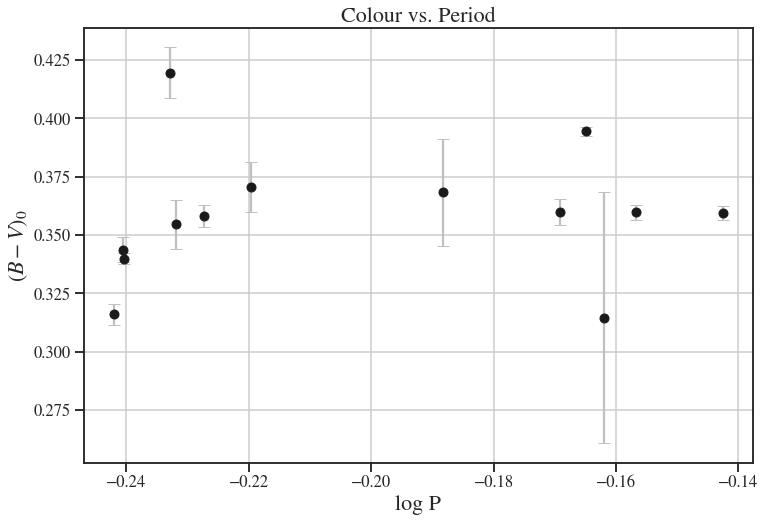

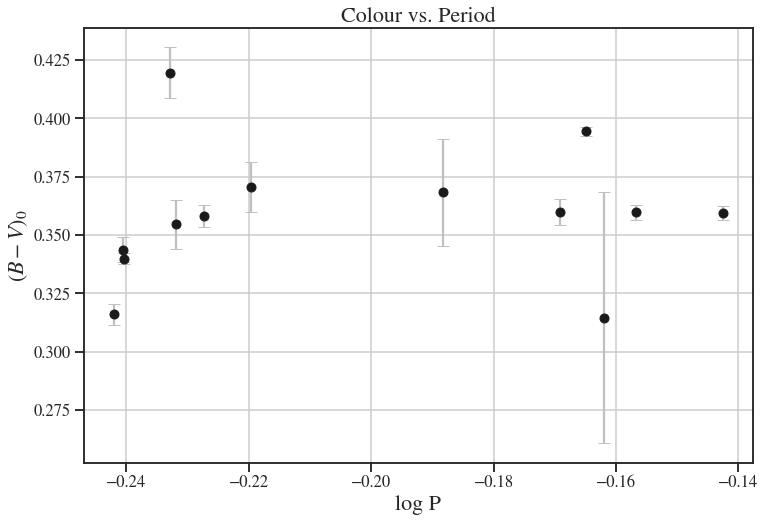

In [80]:
log_period_err_ab = (1/np.log(10)) * (summary[RRab]['P Error'][summary[RRab]['[Fe/H]'] < 0]/summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0])
log_period_err_c = (1/np.log(10)) * (summary[RRc]['P Error'][summary[RRc]['[Fe/H]'] < 0]/summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0])

plt.figure(figsize=(12,8))
plt.title("Colour vs. Period",fontsize=22)
plt.ylabel("$(B - V)_0$",fontsize=22)
plt.xlabel("log P",fontsize=22)
plt.errorbar(np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), summary[RRab]['BV_0'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_BV_0'][summary[RRab]['[Fe/H]'] < 0], fmt='o',
            color='k', ecolor='silver', capsize=6)

plt.grid()
plt.savefig('color_period_KAIT.pdf', format='pdf', dpi=300, bbox_inches='tight') 
plt.show()



log_period_err_ab = (1/np.log(10)) * (summary[RRab]['P Error']/summary[RRab]['period'])
log_period_err_c = (1/np.log(10)) * (summary[RRc]['P Error']/summary[RRc]['period'])

plt.figure(figsize=(12,8))
plt.title("Colour vs. Period",fontsize=22)
plt.ylabel("$(B - V)_0$",fontsize=22)
plt.xlabel("log P",fontsize=22)
plt.errorbar(np.log10(summary[RRab]['period']), summary[RRab]['BV_0'], 
             summary[RRab]['err_BV_0'], fmt='o',
            color='k', ecolor='silver', capsize=6)

plt.grid()
#plt.savefig('color_period.pdf', format='pdf', dpi=300, bbox_inches='tight') 
plt.show()

In [107]:
#summary[]

errors = summary[:][['P Error', 'err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41','err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']]
data = summary[:][['Type', 'period', 'C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']]


In [108]:

data.to_latex('summary.tex',na_rep='-',float_format='{:.3f}'.format)
errors.to_latex('errors.tex',na_rep='-',float_format='{:.3e}'.format)